In [429]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [430]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.1.


In [431]:
import os
os.getcwd()

"C:\\Users\\ianno\\Documents\\Queen's MMA\\MMA 865\\Lecture 6"

## Data Import

In [432]:
df = pd.read_csv("spamraw_train.csv")

In [433]:
#preview the training data
df.info()
df.head()
#observations: 5000 rows, only 3 columns (big one is sms_text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
id          5000 non-null int64
sms_text    5000 non-null object
spam        5000 non-null int64
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


,id,sms_text,spam
0,1,Hope you are having a good week. Just checking in,0
1,2,K..give back my thanks.,0
2,3,Am also doing in cbe only. But have to pay.,0
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1
4,5,okmail: Dear Dave this is your final notice to...,1


## EDA

In [434]:
#check out labels
np.bincount(df['spam'])
#we may want to do some oversampling of our spam class (=1)

array([4327,  673], dtype=int64)

0    0.8654
1    0.1346
Name: spam, dtype: float64

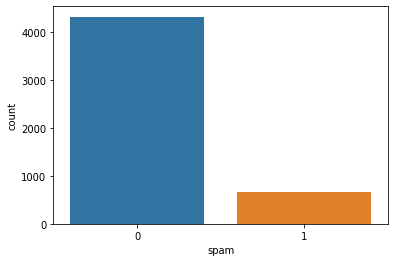

In [435]:
sns.countplot(x='spam', data = df)

df['spam'].value_counts(normalize=True)

#observations: 86% of the labels are ham (certainly have a case of target imbalance here)

## Build Pipeline

In [436]:
from sklearn.model_selection import train_test_split

X = df['sms_text']
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)

In [437]:
#key preprocessing: tokenization, removing punctuation, numbers, stop words, etc.

#import key text mining packages
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
import re
import unidecode

In [438]:
#define stopwords (pull from nltk library)
stop_words = set(stopwords.words('english'))

#define lemmatizer
lemmer = WordNetLemmatizer()
#stemmer = LancasterStemmer()

In [439]:
#define preprocessing function
def preprocess(doc):

    doc = doc.lower() #lower case everything
    
    doc = re.sub(r'http\S+', '', doc) #remove urls
    
    doc = re.sub(r'$)
    
    doc = unidecode.unidecode(doc)
    
    doc = re.sub(r'[^\w\s]', '', doc) #remove punctuation
    
    doc = re.sub(r'\d+', '', doc) #remove any numbers
    
    doc = [lemmer.lemmatize(w) for w in doc.split() if w not in stop_words]
    #doc = [stemmer.stem(w) for w in doc.split() if w not in stop_words]

    return ' '.join(doc)

In [450]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from textstat import flesch_reading_ease, syllable_count
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#define vectorizer
vectorizer = CountVectorizer(max_features = 1000, preprocessor=preprocess, ngram_range = [1,3])

#feature engineering
    #sms length
def get_text_length(x):
    return np.array([len(x) for t in x]).reshape(-1, 1)

#define ml algorithm
#dt = DecisionTreeClassifier(random_state = 1024, min_samples_split = 10, min_samples_leaf = 10, max_depth = 6)
nb = MultinomialNB()
#rf = RandomForestClassifier(random_state = 1024, min_samples_split = 10, min_samples_leaf = 10, max_depth = 20)
#lr = LogisticRegression()
#svc = LinearSVC()

#pipe = Pipeline([('cv', vectorizer), ('clf', nb)])

pipe = Pipeline([('features', FeatureUnion([
    ('text', Pipeline([
        ('vectorizer', vectorizer),
    ])),
    ('length', Pipeline([
        ('count', FunctionTransformer(get_text_length, validate=False)),
    ]))
])),
('clf', nb)])

In [451]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('vectorizer',
                                                                  CountVectorizer(max_features=1000,
                                                                                  ngram_range=[1,
                                                                                               3],
                                                                                  preprocessor=<function preprocess at 0x000001E0C8BFC708>))])),
                                                ('length',
                                                 Pipeline(steps=[('count',
                                                                  FunctionTransformer(func=<function get_text_length at 0x000001E0C89B1A68>))]))])),
                ('clf', MultinomialNB())])

## Model Evaluation

In [452]:
#make predictions on test set
pred_val = pipe.predict(X_test)

In [453]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(confusion_matrix(y_test, pred_val))
print(classification_report(y_test, pred_val))
print("F1 score = {:.2f}".format(f1_score(y_test, pred_val, average='macro')))

[[820  17]
 [ 10 153]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       837
           1       0.90      0.94      0.92       163

    accuracy                           0.97      1000
   macro avg       0.94      0.96      0.95      1000
weighted avg       0.97      0.97      0.97      1000

F1 score = 0.95


## Build Submission

In [305]:
test_df = pd.read_csv("spamraw_test.csv")

In [306]:
pred_test = pipe.predict(test_df['sms_text'])

In [307]:
my_submission = pd.DataFrame({'id': test_df.id, 'predicted': pred_test})
my_submission.head()

,id,predicted
0,12000,1
1,12001,0
2,12002,0
3,12003,0
4,12004,0


In [308]:
#export to csv
my_submission.to_csv('predictions16.csv', index=False)